In [1]:
from random import choices
from statsmodels.stats.proportion import proportion_confint
from tabulate import tabulate

import math
import numpy as np

In [2]:
# The number of times to roll the dice
# 522 matches the blue dice from my previous post: http://alexgude.com/blog/fate-dice-statistics/
COUNT = 522

## Wilson Score Interval

In [3]:
def fate_probability(value):
    """Returns the probability of rolling a value on 4dF.

    Args:
        value (int): The value rolled on 4dF.

    Returns:
        float: The probability of rolling the value, that is P(4dF=value).

    Raises:
        TypeError: If -4 <= value <= 4 and value is not an integer.

    """
    # Outside bounds
    if not -4 <= value <= 4:
        return 0

    # The probability of rolling a sum of 0, 1, 2, 3, 4 (negatives are same probability)
    probability = [19/81, 16/81, 10/81, 4/81, 1/81]

    return probability[abs(value)]

In [4]:
def expected_array(n):
    """ Compute the expected values for each bin given a series of 4dF rolls.

    Args:
        n (int): Number of rolls.

    Returns:
        list: A list of expected number of rolls seen by value.

    """
    result = []
    for value in range(-4, 5):
        exp = fate_probability(value) * n
        result.append(exp)

    return result

In [5]:
expected = np.array(expected_array(COUNT))

lower, upper = np.array(proportion_confint(expected, COUNT, alpha=0.01, method="wilson")) * COUNT

In [6]:
wilson_data = [["Outcome", "Lower Bound", "Upper Bound"]]

for i, (low, up) in enumerate(zip(lower, upper)):
    value = i - 4
    wilson_data.append([value, "{0:.2f}".format(low), "{0:.2f}".format(up)])

print(tabulate(wilson_data, headers="firstrow", tablefmt="pipe"))

|   Outcome |   Lower Bound |   Upper Bound |
|----------:|--------------:|--------------:|
|        -4 |          2.43 |         16.84 |
|        -3 |         15.72 |         41.74 |
|        -2 |         47.52 |         86.31 |
|        -1 |         81.73 |        128.46 |
|         0 |         99.34 |        149.02 |
|         1 |         81.73 |        128.46 |
|         2 |         47.52 |         86.31 |
|         3 |         15.72 |         41.74 |
|         4 |          2.43 |         16.84 |


## Normal Approximation

In [7]:
def variance_expectation(n, sign):
    """Returns the expected range of rolls based on the variance and z score.

    Args:
        n (int): The number of rolls to consider.
        sign (int): -1 returns the lower bounds, +1 returns the upper bounds.

    Returns:
        list: A list of the lower/upper bounds for the values -4, -3, ..., 4.
    """
    weights = expected_array(n)
    output = []
    for i, weight in enumerate(weights):
        value = i - 4
        p = fate_probability(value)
        sigma = sign * 2.58 * math.sqrt(n * p * (1 - p)) + weight
        output.append(sigma)

    return output

In [8]:
upper = variance_expectation(COUNT, 1)
lower = variance_expectation(COUNT, -1)

In [9]:
naive_data = [["Outcome", "Lower Bound", "Upper Bound"]]

for i, (low, up) in enumerate(zip(lower, upper)):
    value = i - 4
    naive_data.append([value, "{0:.2f}".format(low), "{0:.2f}".format(up)])

print(tabulate(naive_data, headers="firstrow", tablefmt="pipe"))

|   Outcome |   Lower Bound |   Upper Bound |
|----------:|--------------:|--------------:|
|        -4 |         -0.06 |         12.95 |
|        -3 |         13.01 |         38.55 |
|        -2 |         45.05 |         83.84 |
|        -1 |         79.64 |        126.58 |
|         0 |         97.47 |        147.42 |
|         1 |         79.64 |        126.58 |
|         2 |         45.05 |         83.84 |
|         3 |         13.01 |         38.55 |
|         4 |         -0.06 |         12.95 |


# Monte Carlo Simulation

In [10]:
# Values to select, and the weights to do it with
WEIGHTS = [1, 4, 10, 16, 19, 16, 10, 4, 1]
VALUES = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

# Bins edges
BINS = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]

In [11]:
def simulate_rolls(n, trials=10000):
    """ Simulate rolling 4dF N times and calculate the expectation intervals.

    Args:
        n (int): The number of times to roll 4dF per trial.
        trials (int): The number of trials to run.

    Returns:
    list: A list of lists, containing the counts for each value for each trial:
        [
            [ count, count, count ... ], # -4
            [ count, count, count ... ], # -3
            ...                        
            [ count, count, count ... ], # +4
        ]                              
    """
    # The possible values we can select, the weights for each, and a histogram binning to let us count them quickly
    values = [-4, -3, -2, -1, 0, 1, 2, 3, 4]
    bins = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    weights = [1, 4, 10, 16, 19, 16, 10, 4, 1]

    results = [[], [], [], [], [], [], [], [], []]

    # Perform a trial
    for _ in range(trials):
        # We select all n rolls "at once" using a weighted choice function
        rolls = choices(values, weights=weights, k=n)
        counts = np.histogram(rolls, bins=bins)[0]
                
        # Add the results to the global result
        for i, count in enumerate(counts):
            results[i].append(count)
    
    return results

In [12]:
%%time 

# Run the simulation
results = simulate_rolls(COUNT, 300000)

CPU times: user 1min 13s, sys: 52 ms, total: 1min 13s
Wall time: 1min 13s


In [13]:
# Print the ranges
simulated_data = [["Outcome", "Lower Bound", "Upper Bound"]]

for i, r in enumerate(results):
    value = i - 4
    p = np.percentile(r, [0.5, 99.5])
    simulated_data.append([value, int(p[0]), int(p[1])])

print(tabulate(simulated_data, headers="firstrow", tablefmt="pipe"))

|   Outcome |   Lower Bound |   Upper Bound |
|----------:|--------------:|--------------:|
|        -4 |             1 |            14 |
|        -3 |            14 |            39 |
|        -2 |            46 |            84 |
|        -1 |            80 |           127 |
|         0 |            98 |           148 |
|         1 |            80 |           127 |
|         2 |            46 |            84 |
|         3 |            14 |            39 |
|         4 |             1 |            14 |


## Probability

In [14]:
def configuration_probability(value, n_times, m_tries):
    """ Give the probability of rolling a value exactly N times on 4dF, given M
    rolls.

    The formula for the probability is:

    (M choose N) * P(Value)^N * P(Not Value)^{M-N}

    Where (M choose N) is the binomial coefficient, P(Value)^N is the
    probability of rolling the value exactly N times, and P(Not Value)^{M-N} is
    the probability of rolling any other result M-N times.

    Args:
        value (int): The value rolled on 4dF.
        n_times (int): The number of times the value should appear.
        m_tries (int): The total number of 4dF rolls.

    Returns:
        float: The probability of the desired combination.
    """
    # Binomial coefficient
    coeff = math.factorial(m_tries) // (math.factorial(n_times) * math.factorial(m_tries - n_times))
    p = fate_probability(value)

    total_probability = coeff * (p**n_times) * ((1-p)**(m_tries-n_times))

    return total_probability

In [15]:
def get_interval(m_tries, start=0.005, end=0.995):
    """Find the lower and upper bounds on the number of times 4dF should roll a
    certain value given m total rolls.

    The lower bound is defined as n such that CP(n) < start < CP(n+1).
    The upper bound is defined as n such that CP(n) < end < CP(n+1)

    CP(n) is the cumulative probability, such that:

        CP(n) = Sum of P(i) for 0 <= i <= n

    Args:
        m_tries (int): The total number of 4dF rolls.

    Returns:
        array of tuples: An array of tuples for the lower and upper bounds
            expected for rolling values -4, -3, -2, -1, 0, 1, 2, 3, 4 on 4dF
            rolled m times. The array has the following form:

            [
                (lower, upper), # Bounds for number of -4s expected
                (lower, upper), # Bounds for number of -3s expected
                ...
                (lower, upper), # Bounds for number of 4s expected
            ]
    """
    output = []
    # Check each 4dF value
    for val in range(-4, 5):
        lower = None
        upper = None
        total_probability = 0

        # Check all possible number of results we could get
        for n in range(m_tries+1):
            total_probability += configuration_probability(val, n, m_tries)
            if total_probability > start and lower is None:
                lower = n
            elif total_probability > end and upper is None:
                upper = n
                break

        output.append((lower, upper))
    return output

In [16]:
intervals = get_interval(COUNT)

In [17]:
# Print the ranges
prob_data = [["Outcome", "Lower Bound", "Upper Bound"]]

for i, (lower, upper) in enumerate(intervals):
    value = i - 4
    prob_data.append([value, lower, upper])

print(tabulate(prob_data, headers="firstrow", tablefmt="pipe"))

|   Outcome |   Lower Bound |   Upper Bound |
|----------:|--------------:|--------------:|
|        -4 |             1 |            14 |
|        -3 |            14 |            39 |
|        -2 |            46 |            84 |
|        -1 |            80 |           127 |
|         0 |            98 |           148 |
|         1 |            80 |           127 |
|         2 |            46 |            84 |
|         3 |            14 |            39 |
|         4 |             1 |            14 |


## Plotting

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("white")

%matplotlib inline

### Comparison

In [19]:
# Plot size
WIDTH = 12
HEIGHT = 7

# A map of plot colors to dice colors. This also sets the order in which they are plotted.
COLORS = (
    (naive_data,"Normal Approximation"),
    (wilson_data, "Wilson Score"),
    (simulated_data, "Monte Carlo"),
    (prob_data, "Binomial Probability"),
)

# Offsets
OFFSETS = []
STEP = 0.1
for i in range(2):
    half = STEP / 2
    position = 0 + half + (half * 2 * i)
    OFFSETS += [-position, position]
OFFSETS.sort()

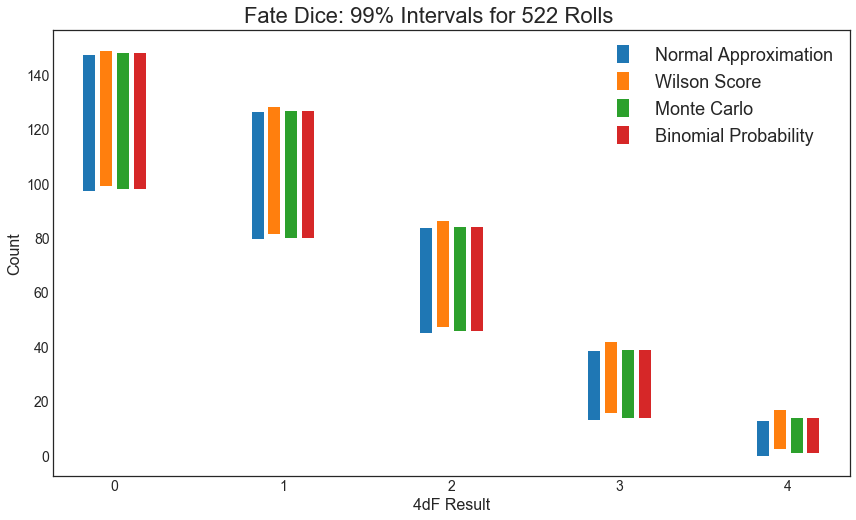

In [20]:
# Set the canvas size
fig = plt.figure(figsize=(WIDTH, HEIGHT))

for i, (data, label) in enumerate(COLORS):
    # Make the data plotable
    cur_data = data[1:]  # Remove the title
    cur_data = [(v, float(l), float(u)) for v, l, u in cur_data]
    values, lower, upper = zip(*cur_data)
    
    # Convert to Numpy arrays for easier operations
    lower = np.array(lower)[4:]
    upper = np.array(upper)[4:]
    
    # Adjust the values for the different options to prevent overlap
    values = np.array(values)[4:]
    offset = OFFSETS[i]
    values = values + offset
    
    # Plot the observed points
    mid = np.array(expected_array(COUNT))[4:]
    y_err_low = mid - lower
    y_err_up = upper - mid
    plt.errorbar(x=values, y=mid, yerr=[y_err_low, y_err_up], fmt="none", linewidth=12, label=label)

ax = plt.gca()
ax.set_xlabel("4dF Result", size=16)
ax.set_ylabel("Count", size=16)
plt.tick_params(axis='both', which='major', labelsize=14)

# Set main title
plt.suptitle("Fate Dice: 99% Intervals for {n} Rolls".format(n=COUNT), y=1.025, fontsize=22)

# Legend
plt.legend(loc="upper right", fontsize=18)

# Make the plots move together
plt.tight_layout()

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/fate_dice_regions.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)

### Probability Distribution

In [21]:
def outcome_probability_distribution(m_tries, outcome=0):
    """Find the probability of rolling a set amount of 4dF for a specific outcome.

    Args:
        m_tries (int): The total number of 4dF rolls.
        outcome (int): The result of rolling 4dF, from -4 to 4.

    Returns:
        array of tuples: Where the first entry of the tuple is the number of
            times the dice showed the outcome, and the second entry is the
            probability.
    """
    output = []

    # Check all possible number of results we could get
    for n in range(m_tries+1):
        probability = configuration_probability(outcome, n, m_tries)
        output.append((n, probability))
    return output

In [22]:
outcome_probability = outcome_probability_distribution(COUNT)

In [23]:
# Set bin sizes
BINS = []
for i in range(0, COUNT):
    BINS.append(i - 0.5)
BINS.append(COUNT + 0.5)

# Colors for the plot
BLUE, *_, RED = sns.color_palette(n_colors=4)

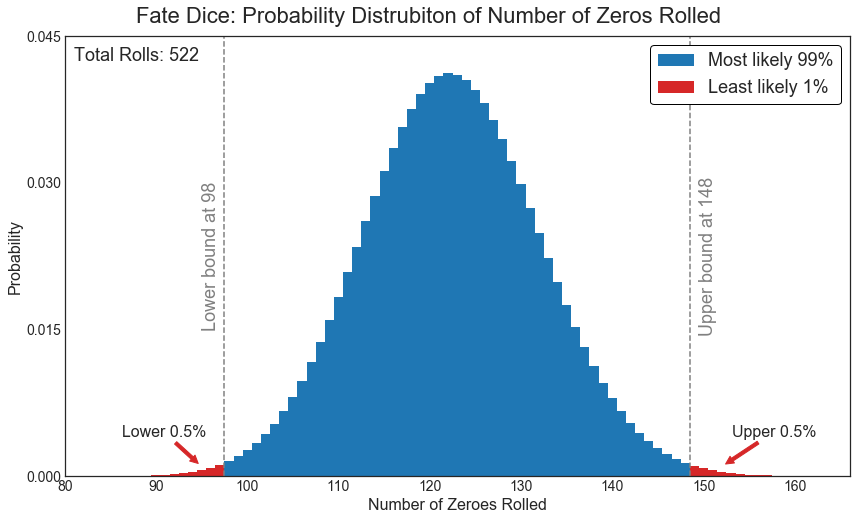

In [24]:
# Set the canvas size
fig = plt.figure(figsize=(WIDTH, HEIGHT))

# Make the data plotable
x, y = zip(*outcome_probability)

# Plot the observed points
plt.hist(x, bins=BINS, weights=y, label="Most likely 99%", color=BLUE)

# Plot the red tails
lower = prob_data[5][1]
upper = prob_data[5][2]
left_x = x[:lower]
left_y = y[:lower]
right_x = x[upper+1:]
right_y = y[upper+1:]
plt.hist(left_x, bins=BINS, weights=left_y, color=RED, label="Least likely 1%")
plt.hist(right_x, bins=BINS, weights=right_y, color=RED)

ax = plt.gca()
ax.set_ylabel("Probability", size=16)
plt.yticks((0, 0.015, 0.03, 0.045))

ax.set_xlabel("Number of Zeroes Rolled", size=16)
ax.set_xlim([80, 148+18])

plt.tick_params(axis='both', which='major', labelsize=14)

# Add arrows
count_arrow = {
    "arrowstyle": "simple",
    "connectionstyle": "arc3",
    "color": RED,
    "shrinkB": 4.5,
}
ax.annotate(
    "Lower 0.5%",
    xy=(95, 0.001),
    xytext=(-80, 30),
    textcoords='offset points',
    arrowprops=count_arrow,
    size=16,
)
ax.annotate(
    "Upper 0.5%",
    xy=(152, 0.001),
    xytext=(10, 30),
    textcoords='offset points',
    arrowprops=count_arrow,
    size=16,
)

# Plot vertical lines for the lower and upper bound
bottom, top = ax.get_ylim()
center = (top - bottom) / 2

ax.axvline(98-0.5, color='.5', linestyle="--")
plt.text(
    97,
    center,
    "Lower bound at 98",
    color='.5',
    size=18,
    rotation='vertical',
    verticalalignment='center',
    horizontalalignment='right',
)

ax.axvline(148+0.5, color='.5', linestyle="--")
plt.text(
    149.5,
    center,
    "Upper bound at 148",
    color='.5',
    size=18,
    rotation='vertical',
    verticalalignment='center',
    horizontalalignment='left',
)

# Add counts
plt.text(81, 0.0425, "Total Rolls: {n}".format(n=COUNT), size=18)

# Set main title
plt.suptitle("Fate Dice: Probability Distrubiton of Number of Zeros Rolled", y=1.025, fontsize=22)

# Legend
legend = plt.legend(loc="upper right", fontsize=18, frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
frame.set_alpha(1)

# Make the plots move together
plt.tight_layout()

# Save to disk
for ext in ("png", "svg"):
    fig.savefig("/tmp/fate_dice_probabilities.{ext}".format(ext=ext), bbox_inches="tight", dpi=300)